In [1]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2

from trasim_simplified.core.kinematics.cfm import get_cf_func
from trasim_simplified.core.constant import CFM

dt = 0.1
cf_name = CFM.IDM
cf_func = get_cf_func(cf_name)
param_names = ["s0", "v0", "T", "omega", "d", "delta"]
# param_names = ["k1", "k2", "thw", "s0"]

In [2]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹
traj_s_full_ori: dict[str, dict] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\ori_dec_acc_traj_s.pkl")
traj_s_cut_pos = {pair_id: len(df_pair) for pair_id, df_pair in traj_s_full_ori["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {pair_id: pd.concat([df_pair, traj_s_full_ori["acc"][pair_id]]) for pair_id, df_pair in traj_s_full_ori["dec"].items()}
obs_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
obs_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
print(len(id_s))

320


In [3]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_run

# 跟驰模型参数标定
results = clb_run(cf_func=cf_func, cf_name=cf_name,
                  obs_x_s=obs_x_s, obs_v_s=obs_v_s, obs_lx_s=obs_lx_s, obs_lv_s=obs_lv_s, leaderL_s=leaderL_s,
                  dt=0.1, seed=2024, drawing=0, n_jobs=4)

Using geatpy


In [4]:
from trasim_simplified.util.calibrate.clb_cf_model import aggregate_result

avg_obj, avg_param, std_obj, std_param = aggregate_result(results)
print(f"avg_obj: {avg_obj}\navg_param: {avg_param}\nstd_obj: {std_obj}\nstd_param: {std_param}")

avg_obj: 16.985627910370717
avg_param: [ 4.1008338  26.3278234   1.06477612  2.47868142  5.08311979  5.996875  ]
std_obj: 9.236824569295067
std_param: [ 2.41441558 14.13936598  0.57043925  2.22372409  3.85295486  3.49865906]


In [5]:
from trasim_simplified.util.calibrate.clb_cf_model import clb_param_to_df

param_df = clb_param_to_df(id_s, results, cf_name)
param_df.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_param_df" + f"_{cf_name}.pkl")
param_df

,s0,v0,T,omega,d,delta,Pair_ID,ObjV
0,5.263910,49.999962,1.541605,1.320260,8.627592,10.0,192,11.514163
1,3.644018,12.264595,0.733242,1.753525,9.999924,10.0,195,9.598012
2,5.456839,13.373985,1.240511,2.796910,6.160598,10.0,196,7.231744
3,6.034975,15.261345,1.485023,1.830330,10.000000,7.0,197,17.875899
4,4.335928,14.275742,1.358891,2.036001,2.749949,10.0,199,11.664526
...,...,...,...,...,...,...,...,...
315,0.000000,35.447350,1.765614,5.206991,1.219058,1.0,6216,10.668306
316,2.136602,39.901276,0.310650,1.500203,0.970608,1.0,6394,17.509274
317,2.732277,26.479301,1.212530,1.613764,8.744552,10.0,6395,6.639412
318,2.590122,16.543350,1.469288,2.777980,10.000000,3.0,6417,19.415002


In [6]:
pd.options.display.precision = 2

param_df[param_names + ["ObjV"]].describe().loc[["mean", "std", "min", "max"]].T

,mean,std,min,max
s0,4.10,2.42,0.00,10.00
v0,26.33,14.16,10.00,50.00
T,1.06,0.57,0.00,3.19
omega,2.48,2.23,0.39,10.00
d,5.08,3.86,0.10,10.00
delta,6.00,3.50,1.00,10.00
ObjV,16.99,9.25,3.71,73.77


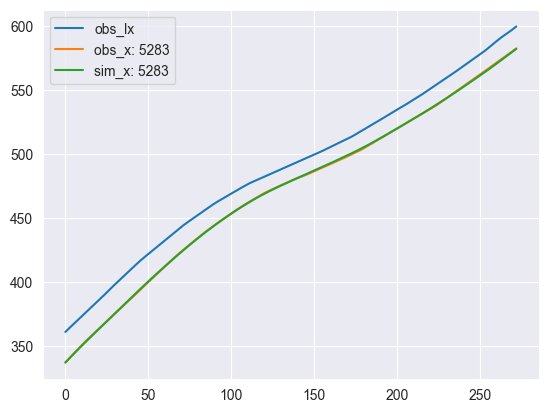

In [7]:
from trasim_simplified.util.calibrate.clb_cf_model import show_traj
import random
import numpy as np

pos = random.choice(range(len(id_s)))
id_ = id_s[pos]
id_ = 5283
pos = np.where(np.array(id_s) == id_)[0][0]

# pos = param_df[param_df[TI.Pair_ID] == 2778].index[0]

target = param_df[param_df[TI.Pair_ID] == id_]
obs_x = obs_x_s[pos]
obs_v = obs_v_s[pos]
obs_lx = obs_lx_s[pos]
obs_lv = obs_lv_s[pos]
leaderL = leaderL_s[pos]
show_traj(cf_name, target.to_numpy().reshape(-1), dt, obs_x, obs_v, obs_lx, obs_lv, leaderL, traj_step=None, pair_ID=id_)

In [8]:
from trasim_simplified.util.tools import save_to_pickle
from trasim_simplified.util.calibrate.clb_cf_model import get_clb_traj

clb_traj_s = get_clb_traj(traj_s_full, traj_s_cut_pos, param_df, cf_func, cf_name, dt)

save_to_pickle(clb_traj_s,
               r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_traj_s" + f"_{cf_name}.pkl")